# Airbnb Listing Price Prediction

## Summary

The listing.csv provides data on ~50K AirBnB listings in New York City. In this notebook, I am going to firstly do a data analysis and then build a model predicting the listing price.

Based on the prediction, i am going to take market demand into account given the predicted price. 

**Data Analysis**
- Price in the data is listing price which means customers who rent the room may end up with a different price. There are some extremely large values but very few
- Geographic Feature tells a lot in listing price. Manhattan and part of Brooklyn (close to Manhattan) have highest listing price.  I am going to guess the high price due from easy communte and more restuarants and shopping area.
- Room type is also able to distinguish listing price. There are three room tpyes: entire apt, private room and shared room. Entire apartment has highest price and shared room has lowest

**Modeling**

Since the time stamp is not in the data, i am going to assume the listing price is an average price over the year. Therefore the prediction is also going to be annual average price. 

Seasonality is an important factor in hotel business. For example, during holiday season, we always expect more people to travel and sightseeing. Larger market demand will push up price because hosters don't need to worry about vacancy issue. In contrast, in low season, hoster need to lower the price to avoid room vacancy. Therefore, Based on the predicted price, i am going to add 30% higher in hot seasons and 10% lower in slow seasons. (the percentage need to justified by more data)

Below is the process of modeling:
- I firstly try out multiple models include linear regression, random forest and xgboost. Xgboost gives best score.
- I build two xgboost models:
    - Exclude "Name" Column: R2 score is 0.56
    - Include "Name" Column (Use PCA to reduce dimension): R2 score is 0.55


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gmaps
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

#### Load Data

In [3]:
lists = pd.read_csv('listings.csv')

In [633]:
lists.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,calculated_host_listings_count,availability_365,number_of_reviews,reviews_per_month,price
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,2,288,46,0.39,225
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,3,1,365,0,NaN,150
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,1,1,212,274,4.64,89
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,10,1,0,9,0.10,80
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,3,1,127,75,0.60,200


In [407]:
print('Num of rows: ' + str(lists.shape[0])) #row count
print('Num of columns: ' + str(lists.shape[1])) #column count

Num of rows: 48864
Num of columns: 15


In [235]:
lists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48864 entries, 0 to 48863
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48864 non-null  int64  
 1   name                            48848 non-null  object 
 2   host_id                         48864 non-null  int64  
 3   host_name                       48846 non-null  object 
 4   neighbourhood_group             48864 non-null  object 
 5   neighbourhood                   48864 non-null  object 
 6   latitude                        48864 non-null  float64
 7   longitude                       48864 non-null  float64
 8   room_type                       48864 non-null  object 
 9   minimum_nights                  48864 non-null  int64  
 10  calculated_host_listings_count  48864 non-null  int64  
 11  availability_365                48864 non-null  int64  
 12  number_of_reviews               

The column "reviews_per_month" has missing value. I am going to impute it later on.

## Data Cleaning

There are several columns not valuable in data analysis and modeling later on: id, host_id and host_name. I am going to drop these columns

In [34]:
to_drop = ['id', 'host_id', 'host_name']
train_space = lists.drop(to_drop, axis = 1)

There are several records with 0 as listing price. I think it is because their listing price is missing. Since missing label provide little information when modeling later on and only a small number are missing (0.02%), i will assign them a very small value and drop them later.

In [47]:
to_drop = ['id', 'host_id', 'host_name']
train_space = train_space.drop(to_drop, axis = 1)

In [48]:
train_space.loc[train_space.price == 0, 'price'] = 0.1

The next column need to be looked at is minimum nights. Some list has minimum_nights as 999. I think this usually means they are open 365 per year. Some listing put 365 in this column. Therefore, in order to make data consistent, i put all of them 365.

In [49]:
train_space.loc[train_space['minimum_nights']>365,'minimum_nights'] = 365

Next, I am going to impute the column "review_per_month"

In [50]:
train_space.reviews_per_month.fillna(0, inplace = True)

Name columns also have null values. I image the listing doesn't have a meaningful name. Therefore, i simply assign a random string to them

In [51]:
train_space.name.fillna('aa', inplace = True)

In [21]:
print('After data cleaning...')
print('Num of rows: ' + str(train_space.shape[0])) #row count
print('Num of columns: ' + str(train_space.shape[1])) #column count

After data cleaning...
Num of rows: 48864
Num of columns: 12


## Data Analysis

### Price (the Label)

I am going to look at the value of listing price first. The minimum value is 0 (missing value) and maximum is 10000. I find it hard to image a room is 10000 per night.However, this is listing price and customers may end up with a lower price. The mean is slightly higher than the median which indicate not too many value with large listing price. the distirbution of price is shown below

In [637]:
train_space.price.describe()

count    48864.000000
mean       151.453197
std        236.585511
min          0.100000
25%         69.000000
50%        105.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

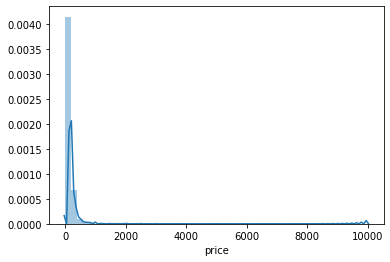

In [638]:
%matplotlib inline
sns.distplot(train_space.price)

In order to avoid model fitting to the  very big outlier, i decided to remove these very big values

In [46]:
train_space = lists[lists.price <= 400]

In [180]:
print('after revmoing these very big values:')
print('Total records: ', train_space.shape[0])


after revmoing these very big values:
Total records:  47197


### Geographic Feature

There are 4 columns in dataframe indicating geographic information for each record

In [19]:
train_space[['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude']].head()

,neighbourhood_group,neighbourhood,latitude,longitude
0,Manhattan,Midtown,40.75362,-73.98377
1,Manhattan,Harlem,40.80902,-73.94190
2,Brooklyn,Clinton Hill,40.68514,-73.95976
3,Manhattan,East Harlem,40.79851,-73.94399
4,Manhattan,Murray Hill,40.74767,-73.97500


(0, 600)

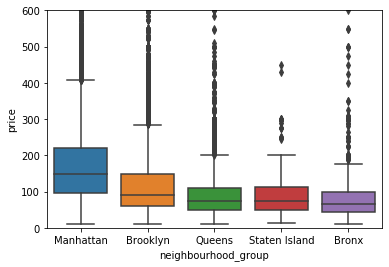

In [31]:
%matplotlib inline
ax = sns.boxplot(x='neighbourhood_group', y='price', data=train_space)
plt.ylim(0, 600)

Manhattan seems to have highest list price and Brooklyn has the second. I am going to look this deeper based on longtitude and latitude.

In [628]:
locations = train_space[[ 'latitude', 'longitude']]
weights = train_space['price']
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig

Figure(layout=FigureLayout(height='420px'))

Based on longtitude and latitude, Manhattan has the highest list price. Part of the brooklyn has high list price esperically the part close to Manhattan. I am going to guess it is because the commute to Manhattan is easy in these areas.

### Correlation

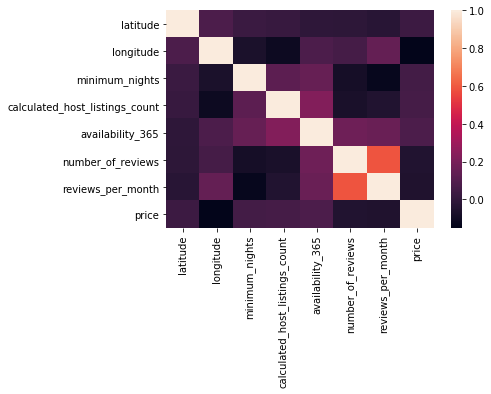

In [34]:
corr = train_space[['latitude', 'longitude',
        'minimum_nights', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews', 'reviews_per_month', 'price']].corr()

# show heapmap of correlations
sns.heatmap(corr)

number_of_revenues and review_per_month has high correlation. Label "price" has low linear correlation with all depentdent variables which imply linear model might not perform well on this. I am going to try out multiple models to see which one get the best score

### Other Feature - Room Type

There are only 3 room types. Entire home has highest price while shared room has the lowest.

(0, 600)

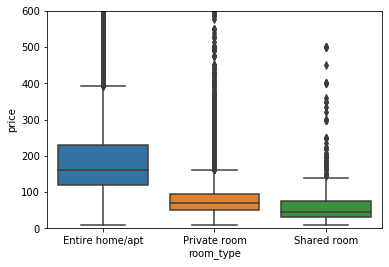

In [438]:
%matplotlib inline
ax = sns.boxplot(x='room_type', y='price', data=train_space)
plt.ylim(0, 600)

## Model

### Model Selection

I am going to keep numerical columns only when selecting the model

In [52]:
train_space_num = train_space[['latitude', 'longitude', 'minimum_nights',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews', 'reviews_per_month','price']]
X = train_space_num.drop('price', axis = 1)
y = train_space.price

In [53]:
train_space_num.shape

(47197, 8)

In [54]:
train_space.isnull().sum()

name                              0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
minimum_nights                    0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews                 0
reviews_per_month                 0
price                             0
dtype: int64

In [55]:
# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' feature')
print('testing data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' feature')

training data has 37757 observation with 7 feature
testing data has 9440 observation with 7 feature


In [56]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [57]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression

# Logistic Regression
regressor_linear = LinearRegression()

# K Nearest Neighbors
regressor_xgb = xgb.XGBRegressor()

# Random Forest
regressor_RF = RandomForestRegressor()


In [58]:
model_names = ['Linear Regression', 'Xgboost', 'Random Forest']
model_list = [regressor_linear, regressor_xgb, regressor_RF ]
count = 0

for regressor in model_list:
    cv_score = model_selection.cross_val_score(regressor, X_train, y_train, cv = 5)
    print(cv_score)
    print('Model score of ' + model_names[count] + ' is ' + str(cv_score.mean()))
    count += 1

[0.11721668 0.13363765 0.11598414 0.1385807  0.12881586]
Model score of Linear Regression is 0.12684700448487315
[0.29534805 0.33184228 0.31862713 0.32015489 0.32523571]
Model score of Xgboost is 0.3182416117965091
[0.30695939 0.343802   0.33360836 0.34152776 0.35404211]
Model score of Random Forest is 0.33598792144317813


Xgboost gives best score. Therefore, i am going to use Xgboost

### Xgboost

I am going to drop column name frist and add back in later on to see any improvement in scores

In [59]:
train_space_xgb = train_space.drop('name', axis =1 )

#### Feature Processing

##### Categorical Features - Label Encoding

In [60]:
le = LabelEncoder()
train_space_xgb['nbh_grp'] = le.fit_transform(train_space_xgb['neighbourhood_group'])
lg = LabelEncoder()
train_space_xgb['nhb'] = lg.fit_transform(train_space_xgb['neighbourhood'])
lf = LabelEncoder()
train_space_xgb['rt'] = lf.fit_transform(train_space_xgb['room_type'])

In [61]:
train_space_xgb = train_space_xgb.drop(['neighbourhood_group', 'neighbourhood', 'room_type'], axis = 1)

##### Apply log on those with heavy tail

In [597]:
train_space_xgb['log_price'] = np.log(train_space_xgb.price)
train_space_xgb['calculated_host_listings_count_log'] = np.log(train_space_xgb.calculated_host_listings_count)
#train_space_xgb['minimum_nights_log'] = np.log(train_space_xgb.minimum_nights)

In [598]:
train_space_xgb = train_space_xgb.drop(['calculated_host_listings_count','price'],axis =1 )

##### Feature Engineering

**Average Price per Neighborhood.** According previous analysis, i find different Manhattan has highest average price. Therefore, i am going to add this feature to help xgboost better predict

In [63]:
nhb_price = train_space_xgb.groupby('nbh_grp').mean().price

In [64]:
nhb_price = nhb_price.reset_index()

In [65]:
nhb_price.columns = ['nhb_grp', 'mean_price_nhb']

In [66]:
train_space_xgb = train_space_xgb.join(nhb_price, on = 'nbh_grp', how = 'inner')

In [67]:
train_space_xgb = train_space_xgb.drop('nhb_grp', axis = 1)

**Average price per room type** According to previous analysis, I find different room type has different price range. Since there are only 3 room types and usually too few categories in one column is weak in prediction, i am going to add average price per room type to help predict

In [68]:
rt_price = train_space_xgb.groupby('rt').mean().price

In [69]:
rt_price = rt_price.reset_index()

In [70]:
rt_price.columns = ['rt', 'mean_price_rt']

In [71]:
train_space_xgb = train_space_xgb.join(rt_price.set_index('rt'), on = 'rt', how = 'inner')

In [72]:
train_space_xgb['rt2'] = train_space_xgb.rt

##### Cross Validation & Model Training

In [181]:
# Remove records with missing labels
train_space_xgb = train_space_xgb[train_space_xgb['price']>0.1]

In [182]:
X = train_space_xgb.drop('price', axis = 1)
y = train_space_xgb.price

In [183]:
# Split into Train and Test set
# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' feature')
print('testing data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' feature')

training data has 37749 observation with 13 feature
testing data has 9438 observation with 13 feature


In [77]:
# This function help print out best parameters in Grid Search
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [78]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': (60,80,100) ,
    'max_depth' : (6,8,10),
    'learning_rate': (0.1,0.01)
}

Grid_xgb = GridSearchCV(xgb.XGBRegressor(), parameters, cv = 5)
Grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=1,
                                    gamma=0, learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=True,
                                    subsample=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': (0.1, 0.01), 'max_depth': (6, 8, 10),
                         'n_estimators': (60, 80, 100)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
            

In [79]:
print_grid_search_metrics(Grid_xgb)

Best score: 0.5616920271550473
Best parameters set:
learning_rate:0.1
max_depth:8
n_estimators:80


Grid Search gives best parameters is learning_Rate: 0.1, max_depth: 8 and n_estimators: 100. However, when i use these parameters in the model, it leads to overfit. Therefore, i lower the max_depth and n_estimators a little bit to overcome this issue

In [184]:
xgb_model = xgb.XGBRegressor(max_depth=6, learning_rate=0.1, n_estimators=80).fit(X_train, y_train)


In [185]:
print('R-squared Score for train set is: ', xgb_model.score(X_train, y_train))
print('R-squared Score for test set is: ', xgb_model.score(X_test, y_test))


R-squared Score for train set is:  0.608582448461253
R-squared Score for test set is:  0.5632012301334544


In [186]:
importances = xgb_model.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), X_train.columns), reverse=True):
    print (v + ": " + str(k))

Feature importance ranking by Random Forest Model:
latitude: 0.2153
longitude: 0.195
availability_365: 0.1351
minimum_nights: 0.1043
calculated_host_listings_count: 0.089
reviews_per_month: 0.0752
number_of_reviews: 0.0748
nhb: 0.0577
rt: 0.045
mean_price_nhb: 0.0054
nbh_grp: 0.0032
rt2: 0.0
mean_price_rt: 0.0


According to the xgboost model, Latitude and Longitude are the most important. This matches to my analysis. That is location matters a lot. The next important feature is availability_365. Since this data doesn't contain time stamps, I am going to guess the listing price is an annual average. Usually, hotel and Airbnb's price is impacted by seasonality a lot. Those with high value in availability include listing price in both high and low seasons.

#### Column "Name"

I am going to do a quick NLP and add back to original datasets to see if any improvement in R2 score.

In [83]:
names = train_space['name']

In [84]:
name_values = names.values

In [85]:
name_lst = []
for n in name_values:
    str_curr = ''
    for c in n:
        if c.isalnum() or c == ' ':
            str_curr = str_curr + c
    #print(str_curr)
    name_lst.append(str_curr)
    

In [86]:
import nltk
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
print('We use ' + str(len(stopwords)) + ' stop words from nltk library')
print(stopwords[:10])

We use 179 stop words from nltk library
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [87]:
from nltk.stem.snowball import SnowballStemmer
import re


#tokenization 
def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word  not in stopwords]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [88]:
# apply tokenizationfor all the documents

docs_tokenized = []
for i in name_lst:
    
    tokenized_results = tokenization(i)
    #print(i)
    #print(tokenized_results)
    docs_tokenized.extend(tokenized_results)

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [90]:
tfidf_model = TfidfVectorizer(max_df=0.99, max_features=1000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=tokenization, ngram_range=(1,1))


In [91]:
tfidf_matrix = tfidf_model.fit_transform(name_lst) #fit the vectorizer to synopses

In [92]:
print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " names and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 47197 names and 83 terms.


In [93]:
tfidf_array = tfidf_matrix.toarray()

**Dimension Reduction**: since there are 86 columns which are a lot and sparse columns usually doesn't perform well in decision trees, I am going to use PCA to see if any opporunity to reduce dimension.

In [94]:
from sklearn.decomposition import PCA
pca = PCA()
reduced = pca.fit_transform(tfidf_array)

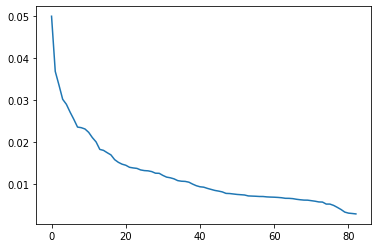

In [95]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

the first 40 components give most information

In [154]:
pca = PCA(75)
name_reduced = pca.fit_transform(tfidf_array)

In [155]:
name_reduced_df = pd.DataFrame(name_reduced)

In [156]:
train_space_new = pd.concat([train_space_xgb, name_reduced_df],axis = 1)

In [166]:
train_space_xgb.shape

(47187, 14)

In [167]:
name_reduced_df.shape

(47197, 75)

In [157]:
train_space_new = train_space_new[train_space_new.price > 0.1]

In [158]:
X = train_space_new.drop('price', axis = 1)
y = train_space_new.price

In [159]:
# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' feature')
print('testing data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' feature')

training data has 37749 observation with 88 feature
testing data has 9438 observation with 88 feature


In [173]:
# original data set
X_train_xgb = X_train.iloc[:,:14]
X_test_xgb = X_test.iloc[:,:14]

In [175]:
xgb_model_reduced = xgb.XGBRegressor()
xgb_model_reduced = xgb.XGBRegressor(max_depth=6, learning_rate=0.1, n_estimators=80).fit(X_train_xgb.values, y_train.values)

In [177]:
print('original model:')
print('The R-squared score for train set is: ', xgb_model_reduced.score(X_train_xgb.values, y_train.values))
print('The R-squared score for train set is: ', xgb_model_reduced.score(X_test_xgb.values, y_test.values))

original model:
The R-squared score for train set is:  0.6072090904345844
The R-squared score for train set is:  0.5616466111095495


In [178]:

xgb_model = xgb.XGBRegressor()
xgb_model = xgb.XGBRegressor(max_depth=6, learning_rate=0.1, n_estimators=80).fit(X_train.values, y_train.values)


In [179]:
print('After adding Name Column:')
print('The R-squared score for train set is: ', xgb_model.score(X_train.values, y_train.values))
print('The R-squared score for train set is: ', xgb_model.score(X_test.values, y_test.values))

After adding Name Column:
The R-squared score for train set is:  0.6244213644064804
The R-squared score for train set is:  0.5508015208269055


The R2 score is not improved in test set after adding in the name column but cause overfit